LLaVA-OneVision
===

## LLaVA-OneVision: Easy Visual Task Transfer

Paper: https://arxiv.org/abs/2408.03326

![LLaVA-OneVision Overview](../assets/llava-onevision-overview.png)

```bash
pip install torch torchvision
pip install transformers
pip install matplotlib
pip install supervision
```

In [2]:
import base64
from io import BytesIO
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

processor = AutoProcessor.from_pretrained(
    "llava-hf/llava-onevision-qwen2-7b-ov-hf"
) 
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    "llava-hf/llava-onevision-qwen2-7b-ov-hf",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    device_map="cuda:0"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
image1 = Image.open("../samples/fruits-01.jpg")

def load_image_as_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

image1_base64 = load_image_as_base64(image1)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "data:image/jpeg;base64," + image1_base64},
            {"type": "text", "text": "What is shown in this image?"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation, add_generation_prompt=True,
    tokenize=True, return_dict=True, return_tensors="pt"
)
inputs = inputs.to("cuda:0", torch.float16)

inputs.keys()


dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_sizes'])

In [4]:
output = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


user 
What is shown in this image?assistant
The image shows a collection of fruits and vegetables, including blueberries, raspberries, cucumbers, and possibly some other items that are not clearly identifiable. The focus is on the fresh produce, which is arranged in a way that highlights the variety and colors of the fruits and vegetables.


In [6]:
image2 = Image.open("../samples/plants.jpg")
image2_base64 = load_image_as_base64(image2)

conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "data:image/jpeg;base64," + image2_base64},
            {"type": "text", "text": "What is shown in this image?\n"},
        ],
    },
]

inputs = processor.apply_chat_template(
    conversation, add_generation_prompt=True,
    tokenize=True, return_dict=True, return_tensors="pt"
)
inputs = inputs.to("cuda:0", torch.float16)

output = model.generate(**inputs, max_new_tokens=100)
print(processor.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


user 
What is shown in this image?
assistant
The image shows two potted plants with a modern design. The pots have a metallic finish, and the plants appear to be well-maintained. The background is a plain wall, which helps to focus on the potted plants.


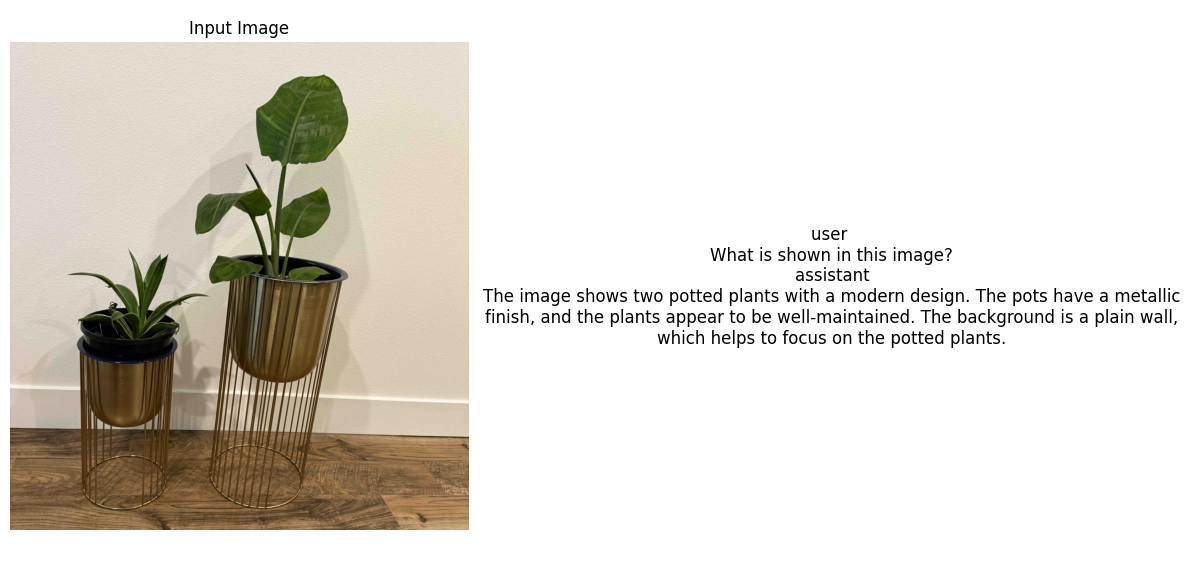

In [7]:
import matplotlib.pyplot as plt

response = processor.decode(output[0], skip_special_tokens=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image2)
axes[0].axis("off")
axes[0].set_title("Input Image")
axes[1].text(
    0.5, 0.5, response,
    fontsize=12, ha="center", va="center", wrap=True
)
axes[1].axis("off")
plt.tight_layout()
plt.show()